In [147]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib import style
from collections import Counter
import re
from geotext import GeoText
from wordcloud import WordCloud
from PIL import Image
import math
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import string
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from fuzzywuzzy import process
import random
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
style.use('fivethirtyeight')


In [148]:
# constants
DATA_PATH = '../data/'
JOBS_PATH = DATA_PATH + 'jobs/'
IMG_PATH = DATA_PATH + 'images/'

In [149]:
try:
    df = pd.read_pickle(JOBS_PATH + 'monster-jobs.pickle')
except FileNotFoundError:
    df = pd.read_csv(JOBS_PATH + 'monster-jobs.csv')
    df.to_pickle(JOBS_PATH + 'monster-jobs.pickle')

LENGTH = len(df)

In [150]:
descriptions = df['job_description']
job_titles = df['job_title']


In [151]:
stop_words = set(stopwords.words('english'))
# additional stop words found in dataset
additional_stop_words = set(['Job','OpportunityAffirmative','Opportunity', 'monster','Most', 'Date', 'Apex', 'monster.com','Monstercom', 'MONS_LOG_VARS', 'var', 'ejb_header', 'JobID', 'Of', ])
stop_words = stop_words.union(additional_stop_words)

In [152]:
def get_column_word_counter(column):
    all_tokens = []
    location_tokens = []
    for elm in column:
        tokens = word_tokenize(elm)
        for token in tokens:
            stripped = re.sub(r'\W+', '', token)
            if stripped not in stop_words:
                if len(stripped) > 0:
                    loc = GeoText(stripped)
                    if(len(loc.cities) > 0):
                        location_tokens.append(stripped)
                    else:
                        all_tokens.append(stripped)  
    return Counter(all_tokens), Counter(location_tokens), all_tokens, location_tokens 


In [153]:
def make_US_word_cloud(locations):
    # https://lollyjane.com/wp-content/uploads/2014/05/free-united-states-silhouette.jpg
    us_img = np.array(Image.open('../data/images/us-stencil.png'))
    
    wc = WordCloud(background_color="white", max_words=2000, mask=us_img,
                  stopwords=stop_words)
    wc.generate_from_frequencies(locations)
    wc.to_file(IMG_PATH + 'location-word-cloud.png')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    

In [154]:
'''
function returns a counter object containing all locations mined from location column
'''
def get_location_counter(column):
    all_noun_tokens = []
    location_tokens = []
    
    for elm in column:
        # tokenize location as a sentence
        # needed because some elements contain alot of text
        sent = sent_tokenize(elm)
        for sent_tok in sent:
            # tokenize sentece
            words = word_tokenize(sent_tok)
            # tag words by part of speech
            tagged = nltk.pos_tag(words)
            nouns = []
            # collect all proper nouns
            for tup in tagged:
                if tup[1] == 'NNP':
                    nouns.append(tup[0])
            all_noun_tokens.append(nouns)
    
    for token in all_noun_tokens:
        tagged = nltk.pos_tag(token)
        # create named entity from all nouns
        namedEnt = nltk.ne_chunk(tagged, binary=True)
        for ent in namedEnt:
            if(hasattr(ent, 'label') and ent.label() == 'NE'):
                location_str = ' '.join(e[0] for e in ent)
                # find combined entities such as San Jose, Las Vegas, etc
                loc = GeoText(location_str)
                if(len(loc.cities) > 0):
                    location_tokens.append(location_str.title())
    return Counter(location_tokens)
         

In [155]:
locations = df['location']
loc_counter = get_location_counter(locations)

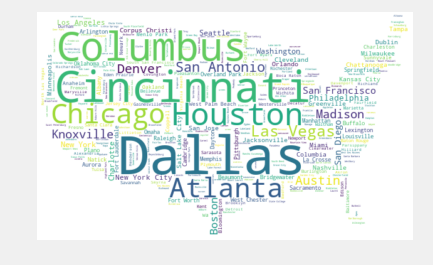

In [22]:
make_US_word_cloud(loc_counter)

In [23]:
organization = df['organization']
sector = df['sector']

In [125]:
def find_industries(sector):
    all_tokens = []
    for sec in sector:
        words = word_tokenize(str(sec))
        for word in words:
            if word not in stop_words:
                all_tokens.append(word)
    return Counter(all_tokens)

def strip_word_remove_location(word):
    word = word.translate(translator)
    loc = GeoText(word)
    return word if len(loc.cities) == 0 and word != 'nan' else ''

def combine_industries(sector, organization, stop_words, industry_features):
    all_tokens = []
    industry_stop_words = set(['All','Not', 'Services','Other','Entry','Level', 'Development', 'R', 'D'])
    stop_words = stop_words.union(industry_stop_words)
    sector_org_df = pd.DataFrame()
    
    for i in range(len(df)):
        stripped_sec = strip_word_remove_location(str(sector[i]))
        stripped_org =  strip_word_remove_location(str(organization[i]))
        combined_str = stripped_sec + ' ' + stripped_org

        words = word_tokenize(combined_str)
       
        temp_tokens = []
        words_length = len(words)
        if(len(words) > 0):
            for word in words:
                if(words_length < 20):
                    if word not in stop_words:
                        all_tokens.append(word.lower())
                        temp_tokens.append(word.lower())
            label = 'Unkown'
            found = False
            
            for token in temp_tokens:
                fuzzy_match = process.extract(token, industry_features, limit=1)
                if(fuzzy_match[0][1] > 90):
                    # generating labels with fuzzy matching
                    # can improve
                    #print('Words: ', temp_tokens, end=' Label: ')
                    label = fuzzy_match[0][0]
                    industry_w_label = pd.DataFrame([[combined_str, label]], columns=['industry_text', 'industry'])
                    sector_org_df = sector_org_df.append(industry_w_label,  ignore_index=True)
                    found = True
                    break
                    
            #if (not found):
                #industry_w_label = pd.DataFrame([[combined_str, label]], columns=['industry_text', 'industry'])
                #sector_org_df = sector_org_df.append(industry_w_label)
                
        #print(temp_tokens)  
        #tagged = nltk.pos_tag(temp_tokens)
        #namedEnt = nltk.ne_chunk(tagged, binary=True)
        #print(namedEnt)
    return Counter(all_tokens), sector_org_df

In [126]:
industry_features = set(['Executive', 'Sofware', 'Retail', 'Healthcare', 'Finance', 'Transportation', 'Construction', 'Engineering', 'Manufacturing'])        

In [137]:
industry,combined_df = combine_industries(sector, organization, stop_words, industry_features)

In [142]:
word_features = [tup[0] for tup in industry.most_common(100)]
def find_features(row):
    words = set([word.lower() for word in word_tokenize(row)])
    word_feature_dict = {}
    for word in word_features:
        word_feature_dict[word] = (word in words)
    return word_feature_dict

def make_train_test_data():
    data  = []
    for _,row in combined_df.iterrows():
        data.append((find_features(row['industry_text']), row['industry']))
    return data

In [143]:
industry_data = make_train_test_data()
random.shuffle(industry_data)
training_set = industry_data[:6000]
test_set = industry_data[6000:]

In [146]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test_set))


BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test_set))

BNB_classifier.classify(find_features('software developer'))

MultinomialNB accuracy percent: 0.9803227075954348
BernoulliNB accuracy percent: 0.9925226288862653


'Sofware'